## Описание задания 
Выгрузка представляет собой разбитые по регионам данные о регистрациях пользователей и активации кодов некой промокампании.
Механика кампании самая простая: активируй код с промо упаковки и получи деньги на счет мобильного телефона. Регистрация производится в момент активации первого кода пользователя.

Задачи:
Визуализировать полученные данные в любом инструменте по выбору кандидата (можно Excel, но предпочтительны BI системы - PowerBI, Tableau, SuperSet, DataLens и т.п.) 
Визуализации должны служить одной цели - быть понятными и четкими для изучения и формулирования выводов.
Тип и количество визуализаций - на усмотрение кандидата. 

Для упрощения задачи, ряд вопросов, на которые надо дать ответ на основании данных:

1. Как обстояла ситуация с логистикой промо-продукции на старте акции? В какой момент ситуация изменилась?
2. Как выглядит региональная структура дистрибуции продукта? 
3. Есть ли версии, где находится производство?
4. Есть ли какая-либо закономерность в периодических выбросах?
5. Можно ли сделать какие-либо выводы о категории промо-продукта? Какими особенностями он обладает?

Любые дополнительные выводы, помимо ответов на указанные выше вопросы, только приветствуются.

Результатом работы должна быть небольшая презентация Powerpoint - кол-во слайдов на усмотрение, но в любом случае не более 10.
Удачи!

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('ggplot')
import seaborn as sns
import datetime

## Ознакомление и подготовка данных 

In [2]:
# загрузка данных 
df = pd.read_csv(r"..\initial_data\test data.csv", encoding='cp1251',  delimiter=',' , 
                 quoting=3, converters={'Week':lambda a: int(a[1:]), 'Event_Name':lambda a: a[2:-3]})

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663 entries, 0 to 662
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Week                  663 non-null    int64 
 1   Date                  663 non-null    object
 2   Event_Count           663 non-null    int64 
 3   FederalDistrict_Name  663 non-null    object
 4   Event_Name            663 non-null    object
dtypes: int64(2), object(3)
memory usage: 26.0+ KB


In [3]:
# столбец "Date" 

# переводим столбец в дататайм  
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d %H:%M:%S') 

print('Длительность промоакции:', df['Date'].nunique(), 'дней')
## судя по логам (регистрация и активация) промоакция длилась 38 днях

# добавление столбеца с днем недели 0-пн. 6-вс.
df['Week_day'] = df['Date'].dt.weekday

Длительность промоакции: 38 дней


In [4]:
## столбец "Week"

df['Week'].unique()
## список уникальных значений поля "Week" содержит перечень (18-23) недель 
## предположение: 18-23 это номера недель от начала года

# проверим предположение. извлечем из уникальных значений поля "Date" номера недель 
df['Date'].dt.week.unique()
## списки идентичны. можно сделать вывод о том что промоакция началась на 18 неделе, а закончилась на 23

# для наглядности заменим значения поля "Week" 18 - 1; 19 - 2 итд.
df['Week'] = df['Week'].replace({18:1, 19:2, 20:3, 21:4, 22:5, 23:6})
df

C:\Users\avbru\AppData\Local\Temp\ipykernel_23120\1966807698.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['Date'].dt.week.unique()


,Week,Date,Event_Count,FederalDistrict_Name,Event_Name,Week_day
0,1,2018-05-01,117,Central,Регистрация пользователя,1
1,1,2018-05-01,1,Far Eastern,Регистрация пользователя,1
2,1,2018-05-01,10,North Caucasian,Регистрация пользователя,1
3,1,2018-05-01,20,Northwestern,Регистрация пользователя,1
4,1,2018-05-01,5,Siberian,Регистрация пользователя,1
...,...,...,...,...,...,...
658,6,2018-06-07,149,Siberian,Активация кода,3
659,6,2018-06-07,170,Southern,Активация кода,3
660,6,2018-06-07,14,Undefined,Активация кода,3
661,6,2018-06-07,138,Ural,Активация кода,3


In [5]:
## столбец "Event_Count"

df[(df['Date']=='2018-05-01') & (df['FederalDistrict_Name']=='Central')]
## на примере понятна суть поля 
## 2018-05-01 в Central было совершено 117 регистрация пользователя и 123 активаций кода

,Week,Date,Event_Count,FederalDistrict_Name,Event_Name,Week_day
0,1,2018-05-01,117,Central,Регистрация пользователя,1
9,1,2018-05-01,123,Central,Активация кода,1


In [6]:
## столбец "Event_Name"

df['Event_Name'].value_counts()
## вызывает непонимание неравенство значений 

Регистрация пользователя    335
Активация кода              328
Name: Event_Name, dtype: int64

In [7]:
interm_1 = df.groupby(['Date','FederalDistrict_Name']).agg({'Event_Name':'nunique'})
case = interm_1[interm_1['Event_Name']!=2].reset_index().iloc[:, [0,1]].set_index('FederalDistrict_Name')['Date']
interm_1[interm_1['Event_Name']!=2]
## обнаружены 7 инцидентов когда в определенный день в конкретной локации присутствует только один Event_Name
## предположение: активация кода не указывается при отсутствии случаев с повторным участием в акции 

Event_Name
Date       FederalDistrict_Name            
2018-05-01 Far Eastern                    1
           Undefined                      1
           Ural                           1
2018-05-02 Far Eastern                    1
2018-05-04 Far Eastern                    1
2018-05-07 Far Eastern                    1
2018-05-17 Far Eastern                    1

In [8]:
# проверка выдвинутого предположения 
interm_2 = df.groupby(['Date','FederalDistrict_Name']).agg({'Event_Count':lambda x: x.max() - x.min()})
interm_2[interm_2['Event_Count']==0].shape
## предположение о не указании Event_Name "Активация кода" в случаях равенства Event_Name "Регистрация пользователя" не подтвердилась. т.к. случаев указания "Регистрация пользователя", при разности равной 0, нашлось 52

(52, 1)

In [9]:
## на основании имеющейся информации, после изучения подробностей можно сделать вывод о том, что отсутствие Event_Name "Активация кода" в 7 случаях связано с регистрацией на сайте, но следующей за этим активацией кода акции 

# подсчет количества людей зарегистрировавшихся, но не активировавших код  
case_p = 0
for i in range(len(case)):
    case_p += df[(df['Date']==case.values[i]) & (df['FederalDistrict_Name']==case.index[i])]['Event_Count'].iloc[0]
case_p
## суммарное количество человек, зарегистрировавшихся но не активировавших код доступа, равно 10 (данное число является минимально-возможным, выяснить реальное количество людей, зарегистрировавшихся, но не поучаствовавших в акции, не возможно)

10

## Изучение результатов промоакции


#### Масштаб промоакции

In [10]:
# количество людей, участвовавших в промоакции  
total_members = df.groupby(['Event_Name']).agg({'Event_Count':'sum'})

print('Зарегистрировалось:', total_members.loc['Регистрация пользователя'][0])
print('Активировано промокодов:', total_members.loc['Активация кода'][0])
## за все время проведения акции на портале зарегистрировалось 40437 человек 
## за все время проведения акции активирован 45656 промокод
## точного числа уникальных пользователей, активировавших промокоды, из имеющихся данных рассчитать не возможно 

Зарегистрировалось: 40437
Активировано промокодов: 45656


#### Географии промоакции 

In [11]:
## изучение географии проведения промоакции
## исходя из описанных условий промоакции, можно судить о том, что целевым действием была покупка товара, и как индикатор этого действия - активация промокода
## в связи с этим, выделим в отдельный датафрейм логи с активацией промокодов

df_act = df[df['Event_Name']=='Активация кода'].reset_index(drop=True)

In [12]:
# география результатов проведения акции 
geo = df_act.groupby(['FederalDistrict_Name']).agg({'Event_Count':'sum'}).sort_values('Event_Count', ascending=False)
geo['Percent'] = geo['Event_Count'].apply(lambda a: a*100/np.sum(geo['Event_Count']))
print('Процент продаж в центрально-европейской части России: ', round(geo['Percent'].loc['Central'] + geo['Percent'].loc['Volga'], 1), '%', sep='')
geo
## из полученной информации можно судить о том, что основным рынком сбыта для компании является центрально-европейская часть России, на два федеральных округа приходится практически 60% продаж

Процент продаж в центрально-европейской части России: 59.7%


,Event_Count,Percent
FederalDistrict_Name,,
Central,16845,36.895479
Volga,10432,22.849133
Northwestern,5568,12.195549
Ural,4291,9.398546
Southern,4173,9.140091
Siberian,2770,6.067111
North Caucasian,886,1.940599
Undefined,615,1.347030
Far Eastern,76,0.166462


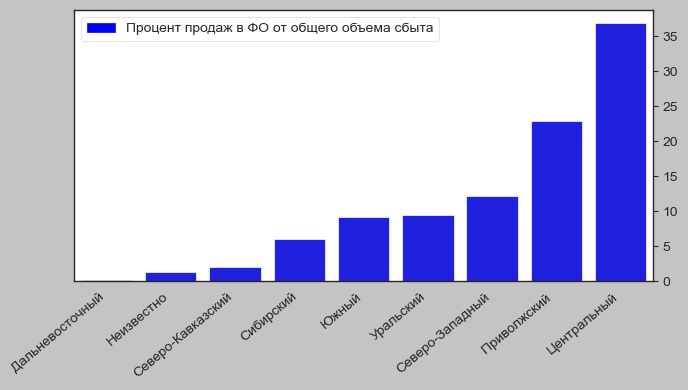

In [15]:
patch = patches.Patch(color='blue', label='Процент продаж в ФО от общего объема сбыта') # патч для легенды 

fig = plt.figure(figsize=(7, 4))
ax1 = fig.add_subplot()
sns.set_style("white") # стиль графика 
fig.set_facecolor((196/255, 196/255, 196/255)) # установка фона фигуры
# ax1.set_facecolor((196/255, 196/255, 196/255)) # установка фона графика
sns.barplot(y=(geo['Percent']), x=geo.index, color='blue') # график 
ax1.yaxis.tick_right() # перенос шкалы Oy на правую часть
ax1.set_xlabel('') # удаление дефолтных наименований осей 
ax1.set_ylabel('') # удаление дефолтных наименований осей 
ax1.set_xticklabels(['Центральный','Приволжский ','Северо-Западный','Уральский','Южный','Сибирский','Северо-Кавказский',
'Неизвестно','Дальневосточный'], rotation=40, ha='right') # поворот наименований элементов 
plt.gca().invert_xaxis() # отражение графика по вертикали (перенос наибольшего значения направо) 
ax1.legend(handles=[patch]) # создание легенды 

fig.tight_layout() # подготовка к сохранению
fig.savefig(r"..\plots\1.png") # сохранение графика 

In [16]:
# активация промокодов в ФО. детализация по неделям 
week_dynam = df_act.groupby(['Week','FederalDistrict_Name']).agg({'Event_Count':'sum'}).reset_index()
order = [1,6,2,4,5,7,3,8,0]

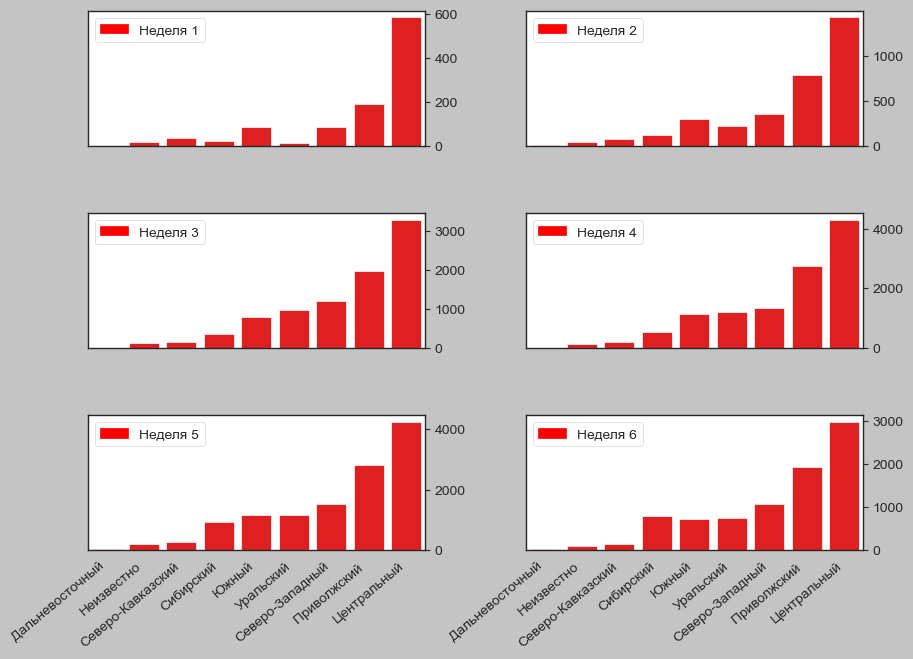

In [17]:
fig = plt.figure(figsize=(10, 7))
gs = fig.add_gridspec(3, 2, hspace=0.5, wspace=0.3)
fig.set_facecolor((196/255, 196/255, 196/255)) # установка фона фигуры
sns.set_style("white") # стиль фона графика 
patch1 = patches.Patch(color='red', label='Неделя 1') # патч для легенды 
patch2 = patches.Patch(color='red', label='Неделя 2')
patch3 = patches.Patch(color='red', label='Неделя 3')
patch4 = patches.Patch(color='red', label='Неделя 4')
patch5 = patches.Patch(color='red', label='Неделя 5')
patch6 = patches.Patch(color='red', label='Неделя 6')

ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(y=(week_dynam[week_dynam['Week']==1].reindex(order)['Event_Count']), 
            x=(week_dynam[week_dynam['Week']==1].reindex(order)['FederalDistrict_Name']), color='red') # график 
ax1.set_xticklabels([]) # удаление наименований баров 
ax1.yaxis.tick_right() # перенос шкалы Oy на правую часть
ax1.set_xlabel('') # удаление дефолтных наименований осей 
ax1.set_ylabel('') # удаление дефолтных наименований осей 
ax1.legend(handles=[patch1]) # создание легенды 
# ax1.set_facecolor((196/255, 196/255, 196/255)) # установка фона графика

ax2 = fig.add_subplot(gs[0, 1])
sns.barplot(y=(week_dynam[week_dynam['Week']==2].reset_index(drop=True).reindex(order)['Event_Count']), 
            x=(week_dynam[week_dynam['Week']==2].reset_index(drop=True).reindex(order)['FederalDistrict_Name']), color='red') # график 
ax2.set_xticklabels([]) # удаление наименований баров 
ax2.yaxis.tick_right() # перенос шкалы Oy на правую часть
ax2.set_xlabel('') # удаление дефолтных наименований осей 
ax2.set_ylabel('') # удаление дефолтных наименований осей 
ax2.legend(handles=[patch2]) # создание легенды 
# ax2.set_facecolor((196/255, 196/255, 196/255)) # установка фона графика

ax3 = fig.add_subplot(gs[1, 0])
sns.barplot(y=(week_dynam[week_dynam['Week']==3].reset_index(drop=True).reindex(order)['Event_Count']), 
            x=(week_dynam[week_dynam['Week']==3].reset_index(drop=True).reindex(order)['FederalDistrict_Name']), color='red') # график 
ax3.set_xticklabels([]) # удаление наименований баров 
ax3.yaxis.tick_right() # перенос шкалы Oy на правую часть
ax3.set_xlabel('') # удаление дефолтных наименований осей 
ax3.set_ylabel('') # удаление дефолтных наименований осей 
ax3.legend(handles=[patch3]) # создание легенды 
# ax3.set_facecolor((196/255, 196/255, 196/255)) # установка фона графика

ax4 = fig.add_subplot(gs[1, 1])
sns.barplot(y=(week_dynam[week_dynam['Week']==4].reset_index(drop=True).reindex(order)['Event_Count']), 
            x=(week_dynam[week_dynam['Week']==4].reset_index(drop=True).reindex(order)['FederalDistrict_Name']), color='red') # график 
ax4.set_xticklabels([]) # удаление наименований баров 
ax4.yaxis.tick_right() # перенос шкалы Oy на правую часть
ax4.set_xlabel('') # удаление дефолтных наименований осей 
ax4.set_ylabel('') # удаление дефолтных наименований осей 
ax4.legend(handles=[patch4]) # создание легенды 
# ax4.set_facecolor((196/255, 196/255, 196/255)) # установка фона графика

ax5 = fig.add_subplot(gs[2, 0])
sns.barplot(y=(week_dynam[week_dynam['Week']==5].reset_index(drop=True).reindex(order)['Event_Count']), 
            x=(week_dynam[week_dynam['Week']==5].reset_index(drop=True).reindex(order)['FederalDistrict_Name']), color='red') # график 
ax5.set_xticklabels(['Дальневосточный','Неизвестно','Северо-Кавказский','Сибирский','Южный',
 'Уральский','Северо-Западный','Приволжский ','Центральный'], rotation=40, ha='right')
ax5.yaxis.tick_right() # перенос шкалы Oy на правую часть
ax5.set_xlabel('') # удаление дефолтных наименований осей 
ax5.set_ylabel('') # удаление дефолтных наименований осей 
ax5.legend(handles=[patch5]) # создание легенды 
# ax5.set_facecolor((196/255, 196/255, 196/255)) # установка фона графика

ax6 = fig.add_subplot(gs[2, 1])
sns.barplot(y=(week_dynam[week_dynam['Week']==6].reset_index(drop=True).reindex(order)['Event_Count']), 
            x=(week_dynam[week_dynam['Week']==6].reset_index(drop=True).reindex(order)['FederalDistrict_Name']), color='red') # график 
ax6.set_xticklabels(['Дальневосточный','Неизвестно','Северо-Кавказский','Сибирский','Южный',
 'Уральский','Северо-Западный','Приволжский ','Центральный'], rotation=40, ha='right')
ax6.yaxis.tick_right() # перенос шкалы Oy на правую часть
ax6.set_xlabel('') # удаление дефолтных наименований осей 
ax6.set_ylabel('') # удаление дефолтных наименований осей 
ax6.legend(handles=[patch6]) # создание легенды 
# ax6.set_facecolor((196/255, 196/255, 196/255)) # установка фона графика

In [18]:
# изучение динамики снижения процента активаций в Центральном ФО от общего объема 

percent_central = []
for i in range(1, 7):
    geo_1 = df_act[df_act['Week']==i].groupby(['Week','FederalDistrict_Name']).agg({'Event_Count':'sum'})
    geo_1['Percent'] = geo_1['Event_Count'].apply(lambda a: a*100/np.sum(geo_1['Event_Count']))
    percent_central.append(geo_1['Percent'][i].loc['Central'])
percent_central  
## доля активаций в центральном ФО снижалась по мере продолжения промоакции 

[56.31629701060752,
 42.84423018981621,
 37.06120612061206,
 37.16554462282065,
 34.582179508063206,
 35.0140383715489]

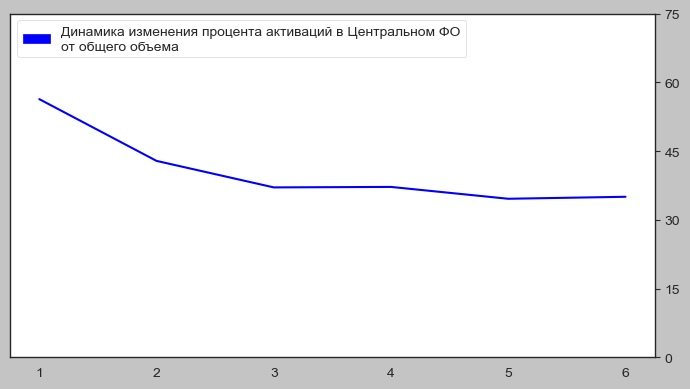

In [19]:
patch = patches.Patch(color='blue', label='Динамика изменения процента активаций в Центральном ФО\nот общего объема') # патч для легенды 

fig = plt.figure(figsize=(7, 4))
ax1 = fig.add_subplot()
sns.set_style("white") # стиль графика 
fig.set_facecolor((196/255, 196/255, 196/255)) # установка фона фигуры
# ax1.set_facecolor((196/255, 196/255, 196/255)) # установка фона графика
sns.lineplot(x=(range(1,7)), y=percent_central, color='blue') # график 
ax1.yaxis.tick_right() # перенос шкалы Oy на правую часть
ax1.set_xlabel('') # удаление дефолтных наименований осей 
ax1.set_ylabel('') # удаление дефолтных наименований осей 
ax1.set_yticks(range(0, int(max(percent_central))+30, 15)) # кастомизация шкалу оси Oy
# ax1.set_yticks(range(0, int(sales_day['Event_Count'].max())+31, 20)) # кастомизация шкалу оси Oy
ax1.legend(handles=[patch], loc='upper left') # создание легенды 

fig.tight_layout() # подготовка к сохранению
fig.savefig(r"..\plots\2.png") # сохранение графика 

#### Тренды промоакции

In [20]:
# динамика изменения объема активаций промокодов. детализация по неделям 

# количество дней в каждой неделе  
df_act.groupby(['Week']).agg({'Week_day':'nunique'})
## первая и последняя недели содержат по 5 дней 

,Week_day
Week,
1,5
2,7
3,7
4,7
5,7
6,5


<AxesSubplot:xlabel='Event_Count', ylabel='Count'>

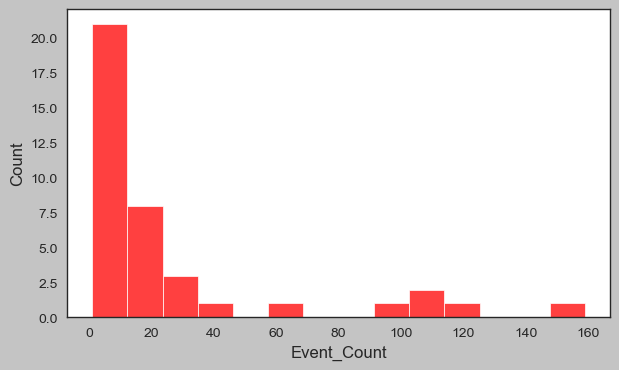

In [21]:
# распределение активаций промокодов на первой неделе
fig = plt.figure(figsize=(7, 4))
fig.set_facecolor((196/255, 196/255, 196/255)) # установка фона фигуры
ax1 = fig.add_subplot()
# ax1.set_facecolor((196/255, 196/255, 196/255)) # установка фона графика
sns.histplot(df_act[df_act['Week']==1]['Event_Count'], color='red')
## у недельных распределений активации промокодов тяжелые хвосты. в дальнейшем необходимо воспользоваться медианой, как мерой более устойчивой к выбросам

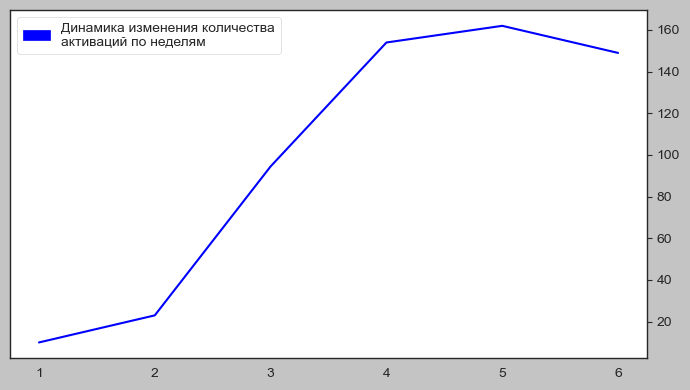

In [22]:
# динамика изменения объема активаций промокодов на протяжении акции 
sales_dynam = df_act.groupby(['Week']).agg({'Event_Count':'median'}).reset_index()

patch = patches.Patch(color='blue', label='Динамика изменения количества\nактиваций по неделям') # патч для легенды 

fig = plt.figure(figsize=(7, 4))
ax1 = fig.add_subplot()
sns.set_style("white") # стиль графика 
fig.set_facecolor((196/255, 196/255, 196/255)) # установка фона фигуры
# ax1.set_facecolor((196/255, 196/255, 196/255)) # установка фона графика
sns.lineplot(x=sales_dynam['Week'], y=sales_dynam['Event_Count'], color='blue') # график 
ax1.yaxis.tick_right() # перенос шкалы Oy на правую часть
ax1.set_xlabel('') # удаление дефолтных наименований осей 
ax1.set_ylabel('') # удаление дефолтных наименований осей 
ax1.legend(handles=[patch]) # создание легенды 

fig.tight_layout() # подготовка к сохранению
fig.savefig(r"..\plots\3.png") # сохранение графика 

## наблюдается обратная динамика на шестой неделе
## предположение: это связано с тем, что акция была остановлена до календарного завершения 6 недели?

<AxesSubplot:xlabel='Event_Count', ylabel='Count'>

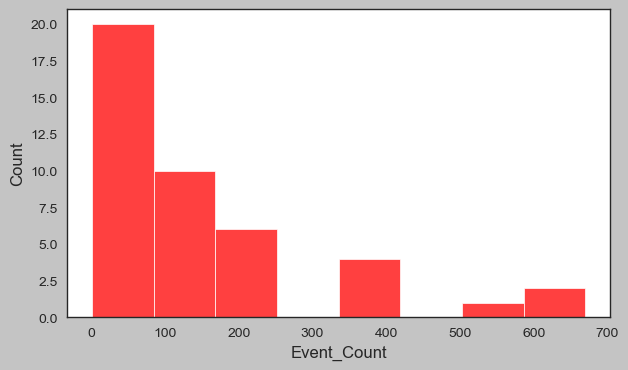

In [24]:
# динамика изменения объема активаций промокодов. детализация по дням 

# распределение активаций промокодов по понедельникам
fig = plt.figure(figsize=(7, 4))
fig.set_facecolor((196/255, 196/255, 196/255)) # установка фона фигуры
ax1 = fig.add_subplot()
# ax1.set_facecolor((196/255, 196/255, 196/255)) # установка фона графика
sns.histplot(df_act[df_act['Week_day']==0]['Event_Count'], color='red')
## у дневных распределений активации промокодов тяжелые хвосты. в дальнейшем необходимо воспользоваться медианой, как мерой более устойчивой к выбросам

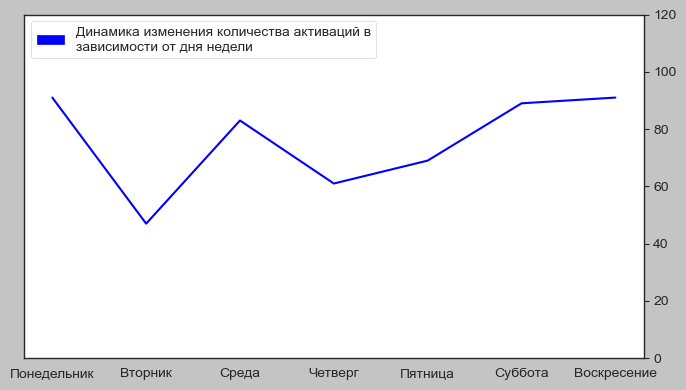

In [25]:
# динамика изменения объема активаций в зависимости от дня недели

sales_day = df_act.groupby(['Week_day']).agg({'Event_Count':'median'}).sort_values('Week_day').reset_index()

patch = patches.Patch(color='blue', label='Динамика изменения количества активаций в\nзависимости от дня недели') # патч для легенды 

fig = plt.figure(figsize=(7, 4))
ax1 = fig.add_subplot()
sns.set_style("white") # стиль графика 
fig.set_facecolor((196/255, 196/255, 196/255)) # установка фона фигуры
# ax1.set_facecolor((196/255, 196/255, 196/255)) # установка фона графика
sns.lineplot(x=['Понедельник','Вторник','Среда','Четверг','Пятница','Суббота','Воскресение'], y=sales_day['Event_Count'], color='blue') # график 
ax1.yaxis.tick_right() # перенос шкалы Oy на правую часть
ax1.set_xlabel('') # удаление дефолтных наименований осей 
ax1.set_ylabel('') # удаление дефолтных наименований осей 
ax1.set_yticks(range(0, int(sales_day['Event_Count'].max())+31, 20)) # кастомизация шкалу оси Oy
ax1.legend(handles=[patch], loc='upper left') # создание легенды 

fig.tight_layout() # подготовка к сохранению
fig.savefig(r"..\plots\4.png") # сохранение графика 

## график подтверждает предположение о снижении количества активаций на последней неделе по причине обрыва эксперимента. т.к. последние "выгодные" дни недели были потерны 
## вызывает недоверие резкое увеличение числа активаций в среду. предположение: присутствие неучтенных факторов

In [26]:
# изучение сред 
df_act[df_act['Week_day']==2]['Date'].unique()
## в двух неделях на среду приходятся выходные дни 2018-05-02 и 2018-05-09. предположение: всплеск активаций связан с ними? 

array(['2018-05-02T00:00:00.000000000', '2018-05-09T00:00:00.000000000',
       '2018-05-16T00:00:00.000000000', '2018-05-23T00:00:00.000000000',
       '2018-05-30T00:00:00.000000000', '2018-06-06T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [27]:
# проверим предположение о том, что праздничные дни влияют на количество активаций в среду
print('Медиана по среде без праздничных дней: ', df_act[~df_act['Date'].isin(['2018-05-02', '2018-05-09'])]['Event_Count'].median())
## предположение не подтвердилось. праздничные дни не влияли на всплеск активности в среду
## игнорирование данных за 2018-05-02 и 2018-05-09 не дало существенного изменения медианы 

Медиана по среде без праздничных дней:  90.0


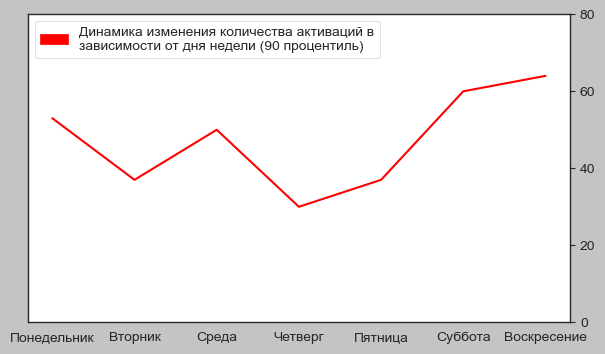

In [29]:
# динамика изменения объема активаций в зависимости от дня недели (90 процентиль)

i = df_act.groupby('Week_day').agg({'Event_Count': lambda x: x[x < x.quantile(0.9)].median()}).sort_values('Week_day').reset_index()

patch = patches.Patch(color='red', label='Динамика изменения количества активаций в\nзависимости от дня недели (90 процентиль)') # патч для легенды 

fig = plt.figure(figsize=(7, 4))
fig.set_facecolor((196/255, 196/255, 196/255)) # установка фона фигуры
ax1 = fig.add_subplot()
sns.set_style("white") # стиль фона графика 
sns.lineplot(x=['Понедельник','Вторник','Среда','Четверг','Пятница','Суббота','Воскресение'], y=(i['Event_Count']), color='red') # график 
ax1.yaxis.tick_right() # перенос шкалы Oy на правую часть
ax1.set_xlabel('') # удаление дефолтных наименований осей 
ax1.set_ylabel('') # удаление дефолтных наименований осей 
ax1.set_yticks(range(0, int(i['Event_Count'].max())+31, 20)) # кастомизация шкалу оси Oy
ax1.legend(handles=[patch], loc='upper left') # создание легенды 
# ax1.set_facecolor((196/255, 196/255, 196/255)) # установка фона графика

# fig.tight_layout() # подготовка к сохранению
# fig.savefig(r"task_2\plots\5.png") # сохранение графика

## взятие 90 процентиль также значимо не повлияло на наличие всплеска активаций в среду

## Результаты промоакции 

- Промоакция длилась 38 дней;
- За все время проведения акции на портале зарегистрировалось 40 437 человек, а также активирован 45 656 промокод. Точного числа уникальных пользователей, активировавших промокоды, рассчитать не возможно по причине недостатка данных;
- На основании имеющейся информации можно сделать предположение, что основным рынком сбыта для компании является центрально-европейская часть России. На два федеральных округа (Центральный и Приволжский) приходится практически 60% продаж;
- Процент активаций промокодов в Центральном ФО от общего объема активаций снизился с 53% до 35% за 6 недель проведения акции. На основании данного обстоятельства можно предположить о том, что производство товаров находится в Центральном ФО. По мере доставки акционных товаров в другие регионы доля активаций в Центральном ФО снижалась;
- Понедельное количество активаций промокодов на протяжение всей акции росло. Снижение на последней неделе произошло по причине завершения эксперимента в середине календарной недели (последние дни недели с прогнозируемо большим числом активаций были потеряны);
- Определить принадлежность акционного товара к определенной категории, на основании динамики изменения количества активаций промокодов в зависимости от дня недели, не возможно, поскольку данные содержат информацию о дате активации промокода, а не дате покупки;
- Для обоснования тренда изменения количества активаций промокодов в зависимости от дня недели необходимо больше ресурсов.   